You can ignore this file, these were tests for RankNET

In [3]:
# %pip install pandas scikit-learn matplotlib seaborn jsonlines tensorflow pydot tqdm

In [18]:
import jsonlines
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

DATA_DIR = 'data'

# Load the corpus and queries data from the provided JSONL files
corpus = []
with jsonlines.open(f'{DATA_DIR}/corpus.jsonl') as reader:
    for obj in reader:
        corpus.append(obj)
queries = []
with jsonlines.open(f'{DATA_DIR}/queries.jsonl') as reader:
    for obj in reader:
        queries.append(obj)

# Load the training data from the task1_train.tsv file into a pandas dataframe
train_df = pd.read_csv(f'{DATA_DIR}/task1_train.tsv', sep='\t', header=0, names=['query_id', 'document_id', 'relevance_score'])

In [19]:
train_df.head(10)

,query_id,document_id,relevance_score
0,1185869,0,1
1,1185868,16,1
2,597651,49,1
3,403613,60,1
4,1183785,389,1
5,312651,616,1
6,80385,723,1
7,645590,944,1
8,645337,1054,1
9,186154,1160,1


In [20]:
# Create a df from from corpus data and make the '_id' column an int64 type
corpus_df = pd.DataFrame(corpus)
corpus_df['_id'] = corpus_df['_id'].astype('int64')

In [21]:
queries_df = pd.DataFrame(queries)
queries_df['_id'] = queries_df['_id'].astype('int64')

In [22]:
# Apply the tf-idf vectorizer to the corpus data, remove stop words
vectorizer = TfidfVectorizer(stop_words='english')
corpus_vectors = vectorizer.fit_transform(corpus_df['text'])

In [23]:
# Apply the tf-idf vectorizer to the queries data, remove stop words
queries_vectors = vectorizer.fit_transform(queries_df['text'])

In [24]:
FEATURE_SIZE = queries_vectors.shape[1]
display(FEATURE_SIZE)

100741

In [25]:
# Unique document ids
import numpy as np

doc_ids = np.unique(train_df['document_id'])
doc_ids.shape

(516472,)

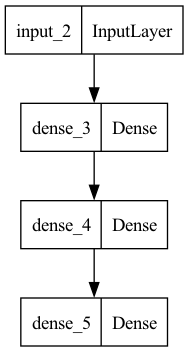

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(1024, activation=leaky_relu), layers.Dense(512, activation=leaky_relu)]
        # We want the final layer to output a ranking for all documents in the corpus for this input query
        self.output_layer = layers.Dense(len(doc_ids), activation=activations.softmax)
    
    def call(self, input):
        x = input
        for layer in self.dense:
            x = layer(x)
        return self.output_layer(x)

    def build_graph(self):
        x = Input(shape=(FEATURE_SIZE,))
        return Model(inputs=[x], outputs=self.call(x))

# visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=False)

In [34]:
# Create df from queries_vectors
queries_vectors_df = pd.DataFrame.sparse.from_spmatrix(queries_vectors)
# Concat the query_id column to the queries_vectors_df
queries_vectors_df = pd.concat([queries_df['_id'], queries_vectors_df], axis=1)
queries_vectors_df.head(10)

,_id,0,1,2,3,4,5,6,7,8,...,100731,100732,100733,100734,100735,100736,100737,100738,100739,100740
0,1185869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1185868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,597651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,403613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1183785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,312651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,80385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,645590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,645337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,186154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Merge the train_df and queries_vectors_df on the query_id column
train_df = train_df.merge(queries_vectors_df, left_on='query_id', right_on='_id')
# Drop the _id column
train_df.drop(columns=['_id'], inplace=True)
train_df.head(10)

,query_id,document_id,relevance_score,0,1,2,3,4,5,6,...,100731,100732,100733,100734,100735,100736,100737,100738,100739,100740
0,1185869,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1185868,16,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,597651,49,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,403613,60,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1183785,389,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,312651,616,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,80385,723,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,645590,944,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,645337,1054,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,186154,1160,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
from tqdm.notebook import tqdm

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(train_df['query_id']):
    # find all document_ids that match the query_id
    query_idx = np.where(train_df['document_id'] == q)[0]
    # generate all possible pairs of document_ids
    for pair_idx in combinations(query_idx, 2):
        # append the document features for each document in the pair to xi and xj
        xi.append(corpus_vectors[pair_idx[0]].toarray()[0])
        xj.append(corpus_vectors[pair_idx[1]].toarray()[0])
        # we append 1 if the first document is more relevant than the second, and 0.5 if they are equally relevant and 0 otherwise
        if train_df['relevance_score'][pair_idx[0]] > train_df['relevance_score'][pair_idx[1]]:
            pij.append(1)
        elif train_df['relevance_score'][pair_idx[0]] == train_df['relevance_score'][pair_idx[1]]:
            pij.append(0.5)
        else:
            pij.append(0)
        # append the pair_id and query_id for each pair
        pair_id.append(pair_idx)
        pair_query_id.append(q)

# convert lists to numpy arrays
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_id = np.array(pair_id)
pair_query_id = np.array(pair_query_id)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [49]:
# split data into train and test sets
xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test, pair_query_id_train, pair_query_id_test = train_test_split(xi, xj, pij, pair_id, pair_query_id, test_size=0.2, random_state=42)

In [51]:
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=50, batch_size=1, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/50
3709/3709 [==============================] - 41s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
3709/3709 [==============================] - 36s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
3707/3709 [============================>.] - ETA: 0s - loss: 0.6931

KeyboardInterrupt: 